# Interpolating Estimated Coefficients

### Q1: Interpretation and significance

Suppose that you would like to know how much families in the US are spending on recreation annually. Use the following estimated model:

$$ expenditure = 873 + 0.0012annual\_income + 0.000002annual\_income^2 - 223.57have\_kids $$

Here, `expenditure` is the annual spending on recreation in US dollars, `annual_income` is the annual income in US dollars, and `have_kids` is a dummy variable indicating the families with children. Interpret the estimated coefficients. What additional statistics can be given in order to ensure that your interpretations make sense statistically? Write up your answer.

**Answer:** We don't know the statistical significance of the coefficients. Therefore, if they were statistically insignificant, then we should consider them as if they are zero. We should have access to the t statistics or respective p-values.

Assuming that all the estimated coefficients are statistically significant, we can interpret the model as follows:

- The `bias` term is 873. As we don't know if it is statistically significant, we have no way of interpreting it other than the value of \$873 when all of the features are zero.

- The dummy variable `have_kids` adds an additional cost of $223.57 per year to a family's annual expenditure.

- The relation between the recreation expenditure and the annual income is quadratic. An increase of \$10,000 in annual income would increase the annual spending on recreation by $12 from `annual_income` in addition to `$0.02 X annual_income`. This is expressed `$0.02 X annual_income` because the exact value depends on `annual_income` and the relationship is quadratic. As the relationship is quadratic, `annual_income^2` will increase as `annual_income` increases.

We can visualize these relationships through the plot below which classifies the relationship between annual spending on recreation and annual income for families with and without children.


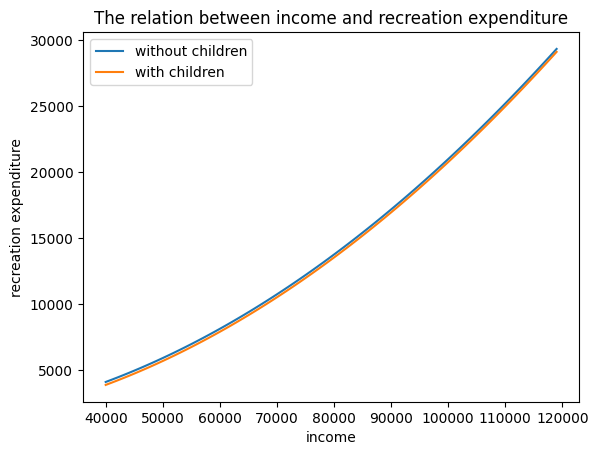

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# X = Annual Income
X = np.arange(40000, 120000, 1000)
# Y = Annual Spending on Recreation (without children)
Y = 873 + 0.0012*X + 0.000002*(X**2)
# Y_kids Annual Spending on Recreation (with children)
Y_children = (873 - 223.57) + 0.0012*X + 0.000002*(X**2)


plt1 = plt.plot(X, Y, label="without children")
plt2 = plt.plot(X, Y_children, label="with children")
plt.xlabel("income")
plt.ylabel("recreation expenditure")
plt.title("The relation between income and recreation expenditure")
plt.legend()
plt.show()

### Q2. Weather Model

In this exercise, we'll work with the historical temperature data from the previous lesson.

- First, load the dataset from the weatherinszeged table from Thinkful's database.
- Build a linear regression model where your target variable is the difference between the apparenttemperature and the temperature. As explanatory variables, use humidity and windspeed. Now, estimate your model using OLS. Are the estimated coefficients statistically significant? Are the signs of the estimated coefficients in line with your previous expectations? Interpret the estimated coefficients. What are the relations between the target and the explanatory variables?
-  Next, include the interaction of humidity and windspeed to the model above and estimate the model using OLS. Are the coefficients statistically significant? Did the signs of the estimated coefficients for humidity and windspeed change? Interpret the estimated coefficients.


**Answer:** We start by loading the usual libraries and by connecting to the database.

In [2]:
import pandas as pd
from sqlalchemy import create_engine, text
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
with engine.begin() as conn:
    query = text("""SELECT * FROM weatherinszeged""")
    weather_df = pd.read_sql_query(query, conn)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222222,7.111111,0.85,13.9587,258.0,14.9569,0.0,1016.66,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733333,5.522222,0.95,12.3648,259.0,9.9820,0.0,1016.72,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772222,6.527778,0.89,14.1519,260.0,9.9820,0.0,1016.84,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822222,10.822222,0.82,11.3183,259.0,9.9820,0.0,1017.37,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772222,13.772222,0.72,12.5258,279.0,9.9820,0.0,1017.22,Partly cloudy throughout the day.


Next, we build a linear regression model where our target variable is the difference between the `apparenttemperature` and the `temperature`. As explanatory variables, use `humidity` and `windspeed`

In [3]:
# The target variable is difference between apparenttemperature and temperature
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# The feature variables are humidity and windspeed
X = weather_df[['humidity','windspeed']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:25:24   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.000       2.397       2.479
humidity      -3.0292      0.024   -126.479      0.000      -3.076      -2.982
windspeed     -0.1193      0.001   -176.164      0.000      -0.121      -0.118
==============================================================================
Omnibus:                     3935.747   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4613.311
Skew:                          -0.478   Prob(JB):                         0.00
Kurtosis:                       3.484   Cond. No.                         88.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These summary statistics tell us that:

- All of the estimated coefficients are statistically significant as the p-values are all zero.
- The signs of the model are not in line with my expectations. As humidity increases, I would expect that the difference between temperature and apparent temperature to increase. In the summer, it often feels warmer than the actual temperarture when it is hot and humid. However, our model has the opposite relationship in which increasing the humidity actually decreases the difference between temperature and apparent temperature. I would also expect that wind speed would increase the difference between temperature and apparent temperature. However, our model shows a negative relationship.
- To find out the relationship between the target and explanatory variables, we can use the instantaneous rate of change from calculus. The coefficient of `-3.0292` tells us that increasing humidity by 1 decreases the target variable by `3.0292`. Analogously, the coefficient of `-0.1193` tells us that increasing windspeed by 1 decreases the target variable by `-0.1193`.

Next, we make a new feature variable to include the interaction of humidity and windspeed and estimate the model using OLS.

In [4]:
 weather_df['humidity_windspeed_interaction'] = weather_df['humidity'] * weather_df['windspeed']

# The target variable is difference between apparenttemperature and temperature
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# The feature variables are humidity and windspeed
X = weather_df[['humidity','windspeed','humidity_windspeed_interaction']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:25:24   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0839      0.033      2.511      0.012       0.018       0.149
humidity                           0.1775      0.043      4.133      0.000       0.093       0.262
windspeed                          0.0905      0.002     36.797      0.000       0.086       0.095
humidity_windspeed_interaction    -0.2971      0.003    -88.470      0.000      -0.304      -0.291
==============================================================================
Omnibus:                     4849.937   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9295.404
Skew:                          -0.378   Prob(JB):                         0.00
Kurtosis:                       4.320   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These summary statistics look significantly more accurate. In particular:

- The p-values of all estimated coefficients are less than `0.05` indicating statistical significance.
- Adding the interaction between humidity and windspeed "fixes" the relationship between humidity/windspeed and the difference in apparent temperature and temperature. Increasing humidity or windspeed now increases the difference between temperature and apparent temperature.
- As before, a 1 point increase in humidity increases the target variable by `0.1775` and a 1 point increase in windspeed increases the target variable by `0.0905`.
- A 1 point increase in the interaction term decrease the target variable by `-0.2971`. This implies that a 1 point increase in humidity results in a `0.1775 - 0.2971 X windspeed` point increase in the target. This means that the increase in the target is lower for high values of windspeed than for low values of windspeed. So, the windspeed mitigates the effect of humidity increase on the target. Similarly for a given humidity level, a 1 point increase in the windspeed results in `0.0905 - 0.2971 X humidity` point increase in the target. So, the humidity also mitigates the effect of windspeed on the target.

### Q3. House prices model

In this exercise, we'll interpret your house prices model.

- Load the houseprices data from Thinkful's database.
- Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?
- Now, exclude the insignificant features from your model. Did anything change?
- Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?
- Do the results sound reasonable to you? If not, try to explain the potential reasons.

In [5]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
with engine.begin() as conn:
    query = text("""SELECT * FROM houseprices""")
    house_price_df = pd.read_sql_query(query, conn)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_price_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


As before, I first cleaned the `bsmtqual` column.


In [6]:
bsmtqual_list = house_price_df['bsmtqual']

for i in range(0, len(bsmtqual_list)):
    if pd.isnull(bsmtqual_list[i]):
        bsmtqual_list[i] = 'TA'

bsmtqual_list.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [7]:
house_price_df['bsmtqual'].isna().sum()

0

I then decided that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the target feature. Therefore, we will turn them into dummy variables.

In [8]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

I think created a regression model with the five non-numerical variables and the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, `totalbsmtsf` which I decided are significant to the target variable.

In [10]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_price_df['saleprice']

# Manually add a constant for the intercept/bias term
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     300.9
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:41:29   Log-Likelihood:                -17374.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1440   BIC:                         3.489e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.277e+04   1.87e+04     -1.756      0.079   -6.94e+04    3841.995
overallqual            1.785e+04   1139.300     15.667      0.000    1.56e+04    2.01e+04
grlivarea                47.5101      2.331     20.384      0.000      42.938      52.082
garagecars              1.13e+04   2888.606      3.910      0.000    5629.241     1.7e+04
garagearea               10.6077      9.898      1.072      0.284      -8.808      30.024
totalbsmtsf              21.1576      2.812      7.523      0.000      15.641      26.674
mszoning_FV            2.452e+04    1.3e+04      1.887      0.059    -971.733       5e+04
mszoning_RH            1.683e+04   1.49e+04      1.130      0.259   -1.24e+04     4.6e+04
mszoning_RL            3.079e+04   1.21e+04      2.551      0.011    7112.717    5.45e+04
mszoning_RM            1.086e+04   1.22e+04      0.888      0.375   -1.31e+04    3.49e+04
street_Pave           -1093.6900   1.53e+04     -0.071      0.943   -3.12e+04     2.9e+04
utilities_NoSeWa      -1.788e+04   3.61e+04     -0.495      0.621   -8.87e+04    5.29e+04
bsmtqual_Fa           -6.357e+04   7835.106     -8.114      0.000   -7.89e+04   -4.82e+04
bsmtqual_Gd           -4.946e+04   4110.818    -12.031      0.000   -5.75e+04   -4.14e+04
bsmtqual_TA           -5.798e+04   4834.945    -11.992      0.000   -6.75e+04   -4.85e+04
salecondition_AdjLand  5015.4464   1.84e+04      0.272      0.786   -3.12e+04    4.12e+04
salecondition_Alloca   7849.9264   1.11e+04      0.705      0.481    -1.4e+04    2.97e+04
salecondition_Family  -7626.0005   8847.348     -0.862      0.389    -2.5e+04    9729.070
salecondition_Normal   9031.0803   3822.143      2.363      0.018    1533.515    1.65e+04
salecondition_Partial  2.016e+04   5246.434      3.843      0.000    9870.008    3.05e+04
==============================================================================
Omnibus:                      597.241   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70631.579
Skew:                          -0.884   Prob(JB):                         0.00
Kurtosis:                      37.029   Cond. No.                     7.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The statistically significant variables are `overallqual`, `grlivarea`, `garagecars`, `totalbsmtsf`, `mszoning_RL`, `bsmtqual_Fa`, `bsmtqual_Gd`, `bsmtqual_TA`, `salecondition_Normal`, and `salecondition_Partial`. All the other variables are statistically insignificant and hence their coefficients are statistically zero. According to the estimation results:

- 1 point increase in `overallqual` results in \$17850 increase in sale price.
- 1 point increase in `grlivarea` results in \$47.5101 increase in sale price.
- 1 point increase in `garagecars` results in \$11300 increase in sale price.
- 1 point increase in `totalbsmtsf` results in \$21.1576 increase in sale price.
- 1 point increase in `mszoning_RL` results in \$30790 increase in sale price.
- 1 point increase in `bsmtqual_Fa` results in \$63570 decrease in sale price.
- 1 point increase in `bsmtqual_Gd` results in \$49460 decrease in sale price.
- 1 point increase in `bsmtqual_TA` results in \$57980 decrease in sale price.
- 1 point increase in `salecondition_Normal` in \$9031.0803 increase in sale price.
- 1 point increase in `salecondition_Partial` in \$20160 increase in sale price.

So, the `bsmtqual_Fa` feature decreases sale price by the most and the `mszoning_RL` feature increases sale price by the most.

We will now exclude statistically insignificant variables from the model and re-estimate it:

In [11]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf','mszoning_RL','bsmtqual_Fa', 'bsmtqual_Gd', 'bsmtqual_TA', 'salecondition_Normal','salecondition_Partial']]
Y = house_price_df['saleprice']

# Manually add a constant for the intercept/bias term
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     569.7
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:42:52   Log-Likelihood:                -17379.
No. Observations:                1460   AIC:                         3.478e+04
Df Residuals:                    1449   BIC:                         3.484e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.284e+04   9045.047     -2.526      0.012   -4.06e+04   -5100.992
overallqual            1.819e+04   1123.006     16.196      0.000     1.6e+04    2.04e+04
grlivarea                47.5979      2.312     20.587      0.000      43.063      52.133
garagecars             1.384e+04   1666.743      8.306      0.000    1.06e+04    1.71e+04
totalbsmtsf              21.0734      2.738      7.696      0.000      15.702      26.445
mszoning_RL            1.698e+04   2411.226      7.043      0.000    1.23e+04    2.17e+04
bsmtqual_Fa           -6.374e+04   7812.817     -8.158      0.000   -7.91e+04   -4.84e+04
bsmtqual_Gd           -4.875e+04   4087.831    -11.925      0.000   -5.68e+04   -4.07e+04
bsmtqual_TA           -5.812e+04   4827.044    -12.040      0.000   -6.76e+04   -4.86e+04
salecondition_Normal   9861.0866   3268.690      3.017      0.003    3449.217    1.63e+04
salecondition_Partial  2.269e+04   4837.792      4.691      0.000    1.32e+04    3.22e+04
==============================================================================
Omnibus:                      580.103   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63804.197
Skew:                          -0.846   Prob(JB):                         0.00
Kurtosis:                      35.342   Cond. No.                     2.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

These results are similar to the results from the previous model. All of the features are statistically significant and once again `bsmtqual_Fa` and `mszoning_RL` have a large impact on the sale price. The `salecondition_Partial` also impacts sale price. These results look reasonable.